<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_LSTM/GRU_LSTM_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 1.58 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 19:35:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Nvidia'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 133 kB 57.8 MB/s 
     |████████████████████████████████| 97 kB 9.1 MB/s 
     |████████████████████████████████| 170 kB 56.2 MB/s 
     |████████████████████████████████| 138 kB 57.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(GRU(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: l62ob2hw
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_LSTM/sweeps/l62ob2hw


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: pj2t9abu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 24s 249ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.0947 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0879
Epoch 2/50
8/8 [==============================] - 1s 112ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0414 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0666
Epoch 3/50
8/8 [==============================] - 1s 106ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0291 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0635
Epoch 4/50
8/8 [==============================] - 1s 107ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0293 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0723
Epoch 5/50
8/8 [==============================] - 1s 112ms/step - loss: 0.0029 - mean_squared_error: 0.

epoch,49
loss,0.00097
mean_squared_error,0.00097
mean_absolute_error,0.01747
val_loss,0.00474
val_mean_squared_error,0.00474
val_mean_absolute_error,0.04868
_runtime,76
_timestamp,1626723478
_step,49
best_val_loss,0.00435


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▃▂▂▂▂▂▁▁▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_loss,▄▂▂▂▃▂█▂▂▂▂▂▂▂▂▁▂▁▃▄▃▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▄▂▂▂▃▂█▂▂▂▂▂▂▂▂▁▂▁▃▄▃▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▄▃▂▃▃▂█▂▂▂▂▂▂▂▂▁▂▂▃▅▃▁▁▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bozyw0iw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 8s 141ms/step - loss: 3.3892 - mean_squared_error: 3.3892 - mean_absolute_error: 0.2661 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0907
Epoch 2/100
31/31 [==============================] - 3s 111ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0534 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0832
Epoch 3/100
31/31 [==============================] - 3s 112ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0420 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0855
Epoch 4/100
31/31 [==============================] - 3s 101ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0362 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1625
Epoch 5/100
31/31 [==============================] - 3s 102ms/step - loss: 0.0048 - mean_squ

epoch,41
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.02877
val_loss,0.00313
val_mean_squared_error,0.00313
val_mean_absolute_error,0.0397
_runtime,148
_timestamp,1626723672
_step,41
best_val_loss,0.00275


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▃█▄▂▂▂▂▁▂▆▁▂▇▂▁▄▁▁▁▂▁▁▂▂▂▃▂▁▁▃▁▇▁▃▂▁▁▁
val_mean_squared_error,▃▃▃█▄▂▂▂▂▁▂▆▁▂▇▂▁▄▁▁▁▂▁▁▂▂▂▃▂▁▁▃▁▇▁▃▂▁▁▁
val_mean_absolute_error,▄▄▄█▅▃▃▃▂▂▃▇▂▃█▃▁▆▁▁▂▃▁▂▃▃▂▄▃▂▁▄▁█▁▄▃▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: s02a2xch with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 141ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - mean_absolute_error: 0.1963 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0650
Epoch 2/200
31/31 [==============================] - 3s 108ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0323 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0488
Epoch 3/200
31/31 [==============================] - 3s 109ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0277 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0445
Epoch 4/200
31/31 [==============================] - 3s 109ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0232 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0460
Epoch 5/200
31/31 [==============================] - 3s 111ms/step - loss: 0.0012 - mean_squ

epoch,76
loss,0.00048
mean_squared_error,0.00048
mean_absolute_error,0.0149
val_loss,0.00256
val_mean_squared_error,0.00256
val_mean_absolute_error,0.03663
_runtime,265
_timestamp,1626723949
_step,76
best_val_loss,0.00196


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▃▄▃▃▄▂▂▃▂▂▂▂▂▃▂▂▁▁▁▁▂▂▂▃▁▁▂▃▂▂▁▁▁▄▁▂
val_mean_squared_error,█▅▅▅▃▄▃▃▄▂▂▃▂▂▂▂▂▃▂▂▁▁▁▁▂▂▂▃▁▁▂▃▂▂▁▁▁▄▁▂
val_mean_absolute_error,█▅▄▄▃▄▃▃▄▂▂▂▂▂▂▂▂▄▂▂▁▁▁▁▂▂▂▃▁▂▃▃▂▂▁▁▂▅▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: aq75kcrr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 7s 125ms/step - loss: 0.0975 - mean_squared_error: 0.0975 - mean_absolute_error: 0.1894 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0867
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0716 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0814
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0282 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0697
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0238 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0860
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0018 - mean_squared_error: 0.

epoch,99
loss,0.00074
mean_squared_error,0.00074
mean_absolute_error,0.01596
val_loss,0.00466
val_mean_squared_error,0.00466
val_mean_absolute_error,0.04693
_runtime,73
_timestamp,1626724033
_step,99
best_val_loss,0.00444


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▆▅▃▆▃▃▃▃▂▅▃▂▃▃▃▃▂▂▂▁▂▁▂▁▂▁▂▂▁▃▁▂▁▁▁▁
val_mean_squared_error,█▆▅▅▆▅▃▆▃▃▃▃▂▅▃▂▃▃▃▃▂▂▂▁▂▁▂▁▂▁▂▂▁▃▁▂▁▁▁▁
val_mean_absolute_error,█▅▄▅▅▄▄▅▃▄▄▄▃▆▃▂▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▃▂▂▁▂▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gq4lpb5u with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 5s 241ms/step - loss: 3.3585 - mean_squared_error: 3.3585 - mean_absolute_error: 0.8607 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1267
Epoch 2/100
8/8 [==============================] - 1s 113ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0923 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1042
Epoch 3/100
8/8 [==============================] - 1s 122ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1010 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0752
Epoch 4/100
8/8 [==============================] - 1s 114ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0665 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0862
Epoch 5/100
8/8 [==============================] - 1s 107ms/step - loss: 0.0200 - mean_squared_error

epoch,27
loss,0.00385
mean_squared_error,0.00385
mean_absolute_error,0.04467
val_loss,0.02549
val_mean_squared_error,0.02549
val_mean_absolute_error,0.14755
_runtime,33
_timestamp,1626724084
_step,27
best_val_loss,0.00428


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁
val_loss,▂▂▂▂█▁█▁▅▃▁▂▁▁▃▂▃▁▁▁▅▂▁▃▁▁▁▃
val_mean_squared_error,▂▂▂▂█▁█▁▅▃▁▂▁▁▃▂▃▁▁▁▅▂▁▃▁▁▁▃
val_mean_absolute_error,▄▃▂▂█▂█▁▆▄▁▃▁▁▄▂▄▁▂▁▆▃▂▄▁▁▂▄
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: nrtml6bm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 8s 138ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_error: 0.0957 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0772
Epoch 2/200
31/31 [==============================] - 3s 112ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0418 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0753
Epoch 3/200
31/31 [==============================] - 4s 113ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0408 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0739
Epoch 4/200
31/31 [==============================] - 3s 110ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0278 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0719
Epoch 5/200
31/31 [==============================] - 3s 107ms/step - loss: 0.0023 - mean_squ

epoch,78
loss,0.00067
mean_squared_error,0.00067
mean_absolute_error,0.01551
val_loss,0.00447
val_mean_squared_error,0.00447
val_mean_absolute_error,0.05358
_runtime,273
_timestamp,1626724384
_step,78
best_val_loss,0.00195


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▄█▅▃▃▂▂▅▂▂▂▃█▃▂▂▂▄▁▂▁▃▁▄▃▁▁▁▂▃▂▁▁▁▁▂▂▃
val_mean_squared_error,▇▇▄█▅▃▃▂▂▅▂▂▂▃█▃▂▂▂▄▁▂▁▃▁▄▃▁▁▁▂▃▂▁▁▁▁▂▂▃
val_mean_absolute_error,▆▆▄▇▅▃▄▃▃▆▃▃▂▄█▄▂▂▂▄▂▂▁▃▁▅▃▁▁▂▃▄▃▁▁▁▁▂▂▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6iufal0a with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 224ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - mean_absolute_error: 0.1717 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1294
Epoch 2/100
8/8 [==============================] - 1s 114ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0430 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0627
Epoch 3/100
8/8 [==============================] - 1s 105ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0251 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.1041
Epoch 4/100
8/8 [==============================] - 1s 106ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0475 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0602
Epoch 5/100
8/8 [==============================] - 1s 111ms/step - loss: 0.0016 - mean_squared_error

epoch,67
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.01752
val_loss,0.00337
val_mean_squared_error,0.00337
val_mean_absolute_error,0.04389
_runtime,72
_timestamp,1626724523
_step,67
best_val_loss,0.00313


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,▅▂▂▅▂▂▂▂▂▃▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁
val_mean_squared_error,▅▂▂▅▂▂▂▂▂▃▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,▆▂▂▆▃▂▂▃▂▄▂▁█▃▁▁▁▂▂▁▁▂▁▁▁▁▂▂▃▁▁▃▁▁▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2521nka0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 143ms/step - loss: 0.0935 - mean_squared_error: 0.0935 - mean_absolute_error: 0.1867 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1068
Epoch 2/200
31/31 [==============================] - 3s 111ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.1026 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0935
Epoch 3/200
31/31 [==============================] - 3s 112ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0406 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0727
Epoch 4/200
31/31 [==============================] - 3s 112ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0246 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0745
Epoch 5/200
31/31 [==============================] - 3s 109ms/step - loss: 0.0013 - mean_squ

epoch,134
loss,0.00071
mean_squared_error,0.00071
mean_absolute_error,0.01599
val_loss,0.00448
val_mean_squared_error,0.00448
val_mean_absolute_error,0.04556
_runtime,469
_timestamp,1626725004
_step,134
best_val_loss,0.00424


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,█▅▅▄▅▄▄▄▃▄▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▅▄▄▄▃▄▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▃▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: f5iyyr37 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 5s 221ms/step - loss: 0.0731 - mean_squared_error: 0.0731 - mean_absolute_error: 0.1778 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0696
Epoch 2/100
8/8 [==============================] - 1s 113ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0292 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1076
Epoch 3/100
8/8 [==============================] - 1s 104ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0337 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0661
Epoch 4/100
8/8 [==============================] - 1s 115ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0362 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0614
Epoch 5/100
8/8 [==============================] - 1s 109ms/step - loss: 0.0015 - mean_squared_error

epoch,37
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02194
val_loss,0.00987
val_mean_squared_error,0.00987
val_mean_absolute_error,0.08791
_runtime,44
_timestamp,1626725099
_step,37
best_val_loss,0.0036


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▃▂▃▂▁▃▂▂▂▂▂▂▂▁▁▂▁▂▁▂▁▂▂▂▁▂▁▁▂▁▁▁▁
val_loss,▂▄▂▂█▂▂▂▂▅▂▂▁▂▄▂▁▂▃▃▁▂▃▂▁▂▂▁▁▁▂▁▄▁▃▁▁▂
val_mean_squared_error,▂▄▂▂█▂▂▂▂▅▂▂▁▂▄▂▁▂▃▃▁▂▃▂▁▂▂▁▁▁▂▁▄▁▃▁▁▂
val_mean_absolute_error,▃▅▂▂█▂▃▂▂▅▂▃▂▃▅▃▂▂▄▄▁▂▄▂▁▃▃▁▂▂▂▁▅▁▄▂▁▄
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: e2t0co16 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 143ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.0977 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1368
Epoch 2/50
31/31 [==============================] - 3s 102ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0378 - val_loss: 0.0622 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.2296
Epoch 3/50
31/31 [==============================] - 3s 105ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0363 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0912
Epoch 4/50
31/31 [==============================] - 3s 109ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0286 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1252
Epoch 5/50
31/31 [==============================] - 4s 114ms/step - loss: 0.0031 - mean_squared_

epoch,49
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.01839
val_loss,0.00281
val_mean_squared_error,0.00281
val_mean_absolute_error,0.03722
_runtime,180
_timestamp,1626725295
_step,49
best_val_loss,0.00281


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▃▃▂▂▁▃▁▁▁▁▁▁▃▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▃▃▂▂▁▃▁▁▁▁▁▁▃▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▄▄▂▃▂▄▂▂▂▂▂▁▄▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: adz00miu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 4s 36ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.0781 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0622
Epoch 2/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0321 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.1028
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0321 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0578
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0254 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0526
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_erro

epoch,44
loss,0.0007
mean_squared_error,0.0007
mean_absolute_error,0.01547
val_loss,0.00345
val_mean_squared_error,0.00345
val_mean_absolute_error,0.04411
_runtime,22
_timestamp,1626725329
_step,44
best_val_loss,0.00229


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▄▃▃▆▂▃▂▇▂▄▂▂▂▂▂▁▁▁▂▂▁▁▂▂▁▃▂▁▆▁▂▂▁▁▁▁▁▂
val_mean_squared_error,▄█▄▃▃▆▂▃▂▇▂▄▂▂▂▂▂▁▁▁▂▂▁▁▂▂▁▃▂▁▆▁▂▂▁▁▁▁▁▂
val_mean_absolute_error,▄█▃▃▄▇▃▃▂▇▂▄▂▂▂▂▃▂▁▂▃▂▁▁▃▂▁▄▂▂▆▁▂▂▁▁▁▁▂▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ro6ptirm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 138ms/step - loss: 0.0846 - mean_squared_error: 0.0846 - mean_absolute_error: 0.1810 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0741
Epoch 2/100
31/31 [==============================] - 3s 110ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0408 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0643
Epoch 3/100
31/31 [==============================] - 3s 107ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0612
Epoch 4/100
31/31 [==============================] - 4s 115ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0218 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0612
Epoch 5/100
31/31 [==============================] - 3s 112ms/step - loss: 0.0016 - mean_squ

epoch,86
loss,0.00083
mean_squared_error,0.00083
mean_absolute_error,0.01829
val_loss,0.00353
val_mean_squared_error,0.00353
val_mean_absolute_error,0.04035
_runtime,307
_timestamp,1626725653
_step,86
best_val_loss,0.00325


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▇██▄▄▄▅▅▃▃▃▂▃▃▃▂▂▂▄▂▂▂▃▂▂▁▂▂▂▂▂▁▃▁▁▁
val_mean_squared_error,█▆▆▆▇██▄▄▄▅▅▃▃▃▂▃▃▃▂▂▂▄▂▂▂▃▂▂▁▂▂▂▂▂▁▃▁▁▁
val_mean_absolute_error,█▅▅▆▅▇▇▄▄▄▄▅▃▃▃▃▃▃▃▃▂▂▄▂▂▂▃▂▂▂▂▂▂▂▂▁▄▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hu8f7qnm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 120ms/step - loss: 0.0785 - mean_squared_error: 0.0785 - mean_absolute_error: 0.1726 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1417
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0872 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1191
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0672 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0906
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0340 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0635
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.001

epoch,72
loss,0.00072
mean_squared_error,0.00072
mean_absolute_error,0.01447
val_loss,0.00528
val_mean_squared_error,0.00528
val_mean_absolute_error,0.05056
_runtime,16
_timestamp,1626725702
_step,72
best_val_loss,0.00512


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jjadhfwk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 63ms/step - loss: 0.0617 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1429 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0737
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0244 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0819
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0246 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0699
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0188 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0646
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0012 - mean_squared_

epoch,88
loss,0.0007
mean_squared_error,0.0007
mean_absolute_error,0.01454
val_loss,0.0035
val_mean_squared_error,0.0035
val_mean_absolute_error,0.04601
_runtime,27
_timestamp,1626725743
_step,88
best_val_loss,0.00322


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▅▃▃▃▃█▄▃▂▆▃▂▂▂▂▂▂▁▃▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▃▁
val_mean_squared_error,▄▄▅▃▃▃▃█▄▃▂▆▃▂▂▂▂▂▂▁▃▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▃▁
val_mean_absolute_error,▄▄▅▃▃▄▃█▄▃▂▇▃▂▂▂▂▂▂▂▄▄▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▄▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uioq2pvb with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 5s 240ms/step - loss: 17.6923 - mean_squared_error: 17.6923 - mean_absolute_error: 1.1222 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - val_mean_absolute_error: 0.3145
Epoch 2/200
8/8 [==============================] - 1s 116ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1557 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1442
Epoch 3/200
8/8 [==============================] - 1s 110ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1052 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1317
Epoch 4/200
8/8 [==============================] - 1s 105ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0944 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1376
Epoch 5/200
8/8 [==============================] - 1s 111ms/step - loss: 0.0133 - mean_squared_err

epoch,54
loss,0.00151
mean_squared_error,0.00151
mean_absolute_error,0.02948
val_loss,0.00431
val_mean_squared_error,0.00431
val_mean_absolute_error,0.05552
_runtime,60
_timestamp,1626725818
_step,54
best_val_loss,0.00303


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▃▄▃▃▁▂▁▂▁▃▁▂▅▁▃▁▁▂▁▂▃▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▃▄▃▃▁▂▁▂▁▃▁▂▅▁▃▁▁▂▁▂▃▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▄▅▄▄▂▃▂▃▁▄▁▄▆▁▅▂▁▂▁▄▅▂▁▁▁▂▁▁▂▃▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fh56giru with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 6s 178ms/step - loss: 0.1638 - mean_squared_error: 0.1638 - mean_absolute_error: 0.2460 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0580
Epoch 2/100
16/16 [==============================] - 2s 113ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0276 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0692
Epoch 3/100
16/16 [==============================] - 2s 115ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0284 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0547
Epoch 4/100
16/16 [==============================] - 2s 117ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0283 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0499
Epoch 5/100
16/16 [==============================] - 2s 116ms/step - loss: 0.0014 - mean_squ

epoch,84
loss,0.00165
mean_squared_error,0.00165
mean_absolute_error,0.02438
val_loss,0.00265
val_mean_squared_error,0.00265
val_mean_absolute_error,0.04199
_runtime,167
_timestamp,1626726026
_step,84
best_val_loss,0.00199


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂
val_loss,▂▂▃▄▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▃▄▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▄▅▂▂▁▂▂█▁▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▃▁▁▁▁▁▂▁▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mvc9gukf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 7s 177ms/step - loss: 0.0874 - mean_squared_error: 0.0874 - mean_absolute_error: 0.1686 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1372
Epoch 2/200
16/16 [==============================] - 2s 106ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0413 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1858
Epoch 3/200
16/16 [==============================] - 2s 110ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0382 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0630
Epoch 4/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0261 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1231
Epoch 5/200
16/16 [==============================] - 2s 104ms/step - loss: 0.0064 - mean_squ

epoch,82
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.01965
val_loss,0.00711
val_mean_squared_error,0.00711
val_mean_absolute_error,0.06974
_runtime,163
_timestamp,1626726204
_step,82
best_val_loss,0.00283


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▃▁▂▁█▁▂▁▁▅▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂
val_mean_squared_error,▄▂▃▁▂▁█▁▂▁▁▅▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂
val_mean_absolute_error,▅▂▄▂▂▂█▁▂▂▂▆▁▂▃▂▂▁▂▁▁▂▂▂▁▁▂▁▁▁▁▁▂▂▁▃▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: licgzaw2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 8s 140ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.0860 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1212
Epoch 2/200
31/31 [==============================] - 3s 111ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0378 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1289
Epoch 3/200
31/31 [==============================] - 3s 112ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0318 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1196
Epoch 4/200
31/31 [==============================] - 3s 107ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0311 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0705
Epoch 5/200
31/31 [==============================] - 3s 108ms/step - loss: 0.0022 - mean_squ

epoch,33
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.01943
val_loss,0.00866
val_mean_squared_error,0.00866
val_mean_absolute_error,0.08349
_runtime,128
_timestamp,1626726346
_step,33
best_val_loss,0.00244


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▃▂▃▂▂▁▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▆▂▂▁▁█▂▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▂▃▁▁▄▁▂▁▁▃
val_mean_squared_error,▇▇▆▂▂▁▁█▂▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▂▃▁▁▄▁▂▁▁▃
val_mean_absolute_error,▆▇▆▃▂▂▂█▂▂▂▂▂▄▁▂▁▂▁▂▁▁▂▁▃▄▁▁▅▁▂▁▁▄
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7enq9zjr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 5s 67ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - mean_absolute_error: 0.1805 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0940
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0416 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0696
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0251 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0640
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0251 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0588
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_er

epoch,185
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01282
val_loss,0.00254
val_mean_squared_error,0.00254
val_mean_absolute_error,0.03438
_runtime,43
_timestamp,1626726427
_step,185
best_val_loss,0.00254


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▆▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▆▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▆▄▄▄▄▄▄▃▃▃▄▃▃▃▃▃▃▂▂▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v5vpl2pc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 7s 173ms/step - loss: 0.0897 - mean_squared_error: 0.0897 - mean_absolute_error: 0.1857 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1304
Epoch 2/50
16/16 [==============================] - 2s 117ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0469 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0742
Epoch 3/50
16/16 [==============================] - 2s 119ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0257 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0701
Epoch 4/50
16/16 [==============================] - 2s 117ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0234 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0863
Epoch 5/50
16/16 [==============================] - 2s 120ms/step - loss: 0.0014 - mean_squared_

epoch,49
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.01939
val_loss,0.00599
val_mean_squared_error,0.00599
val_mean_absolute_error,0.05559
_runtime,104
_timestamp,1626726548
_step,49
best_val_loss,0.00472


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▄▃▅▂▂▂▃▂▂▂▂▂▂▂▁▄▂▁▂▂▂▃▂▄▁▂▂▁▁▆▁▂▂▂▁▁▁
val_mean_squared_error,█▂▃▄▃▅▂▂▂▃▂▂▂▂▂▂▂▁▄▂▁▂▂▂▃▂▄▁▂▂▁▁▆▁▂▂▂▁▁▁
val_mean_absolute_error,█▃▃▄▄▆▂▃▂▄▂▂▂▂▂▂▂▂▅▃▁▂▂▃▃▃▆▁▂▂▁▁█▁▂▃▄▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v9y9x7fj with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 8s 147ms/step - loss: 0.0984 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1646 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0545
Epoch 2/200
31/31 [==============================] - 3s 111ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0341 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0966
Epoch 3/200
31/31 [==============================] - 4s 113ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0305 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0546
Epoch 4/200
31/31 [==============================] - 3s 108ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0349 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1169
Epoch 5/200
31/31 [==============================] - 4s 115ms/step - loss: 0.0020 - mean_squ

epoch,69
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.0154
val_loss,0.00263
val_mean_squared_error,0.00263
val_mean_absolute_error,0.03691
_runtime,256
_timestamp,1626726820
_step,69
best_val_loss,0.00221


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,▂▆█▂▃▂▁▁▃▄▂▂▁▄▁▁▂▁▁▁▁▃▃▁▁▁▂▁▂▂▁▂▁▂▅▁▃▁▂▁
val_mean_squared_error,▂▆█▂▃▂▁▁▃▄▂▂▁▄▁▁▂▁▁▁▁▃▃▁▁▁▂▁▂▂▁▂▁▂▅▁▃▁▂▁
val_mean_absolute_error,▃▆█▂▃▂▂▁▄▆▃▃▁▅▂▂▂▁▁▁▂▄▄▂▁▂▂▁▂▃▁▃▁▃▆▂▄▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g10vlvcq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 5s 66ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - mean_absolute_error: 0.1341 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0735
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0281 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0907
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0311 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1380
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0256 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0684
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0017 - mean_squared_

epoch,27
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.01799
val_loss,0.00716
val_mean_squared_error,0.00716
val_mean_absolute_error,0.06186
_runtime,16
_timestamp,1626726863
_step,27
best_val_loss,0.00606


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▃█▂▄▃▂▂▂▃▂▃▄▅▁▁▁▁▁▂▁▁▂▂▁▃▄▁
val_mean_squared_error,▂▃█▂▄▃▂▂▂▃▂▃▄▅▁▁▁▁▁▂▁▁▂▂▁▃▄▁
val_mean_absolute_error,▃▄█▂▅▃▂▂▂▃▂▄▅▆▂▁▁▁▂▃▂▁▃▂▁▄▅▂
_runtime,▁▁▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: c0n0c6oi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 8s 142ms/step - loss: 0.0405 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1123 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1247
Epoch 2/100
31/31 [==============================] - 3s 109ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0323 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0968
Epoch 3/100
31/31 [==============================] - 3s 111ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0334 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0838
Epoch 4/100
31/31 [==============================] - 3s 113ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0307 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0752
Epoch 5/100
31/31 [==============================] - 4s 115ms/step - loss: 0.0019 - mean_squ

epoch,58
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02009
val_loss,0.00378
val_mean_squared_error,0.00378
val_mean_absolute_error,0.04189
_runtime,219
_timestamp,1626727098
_step,58
best_val_loss,0.00328


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▄▂▅▂▂▂█▂▂▂▂▃▂▃▄▂▁▁▂▁▁▂▃▁▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▄▂▅▂▂▂█▂▂▂▂▃▂▃▄▂▁▁▂▁▁▂▃▁▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▅▄▂▄▂▅▂▂▂█▃▃▂▃▄▂▄▄▃▁▂▂▁▂▂▄▂▂▁▄▁▁▁▂▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 02xdmjbu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 7s 139ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1304 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0721
Epoch 2/200
31/31 [==============================] - 3s 112ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0254 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0853
Epoch 3/200
31/31 [==============================] - 3s 112ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0276 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0702
Epoch 4/200
31/31 [==============================] - 4s 116ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0253 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0734
Epoch 5/200
31/31 [==============================] - 4s 121ms/step - loss: 0.0016 - mean_squ

epoch,104
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.01794
val_loss,0.0038
val_mean_squared_error,0.0038
val_mean_absolute_error,0.04211
_runtime,386
_timestamp,1626727547
_step,104
best_val_loss,0.00363


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▄█▃▂▄▂▂▂▃▂▂▃▃▂▃▂▁▂▁▂▂▁▁▁▁▂▁▂▁▁▂▂▁▁▁▁▁▁
val_mean_squared_error,▄▃▄█▃▂▄▂▂▂▃▂▂▃▃▂▃▂▁▂▁▂▂▁▁▁▁▂▁▂▁▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,▄▄▄█▃▃▄▂▃▃▃▂▂▄▄▃▄▃▂▂▂▂▃▁▁▁▂▂▁▂▁▁▃▃▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zr781ixb with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 5s 270ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - mean_absolute_error: 0.1849 - val_loss: 0.0718 - val_mean_squared_error: 0.0718 - val_mean_absolute_error: 0.2447
Epoch 2/200
8/8 [==============================] - 1s 113ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0694 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1197
Epoch 3/200
8/8 [==============================] - 1s 115ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0458 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0797
Epoch 4/200
8/8 [==============================] - 1s 104ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0360 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0778
Epoch 5/200
8/8 [==============================] - 1s 115ms/step - loss: 0.0030 - mean_squared_error

epoch,63
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.01903
val_loss,0.00538
val_mean_squared_error,0.00538
val_mean_absolute_error,0.0574
_runtime,72
_timestamp,1626727636
_step,63
best_val_loss,0.00488


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▁▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▃▁▁▄▁▁▂▃▂▁▂▂▁▁▂▂▁▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▂▂▂▃▁▁▄▁▁▂▃▂▁▂▂▁▁▂▂▁▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▄▂▂▄▂▂▅▂▂▂▄▂▁▃▂▂▁▂▃▁▄▂▂▂▁▁▁▁▂▂▂▂▁▁▁▁▃▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g74wz6lb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 8s 137ms/step - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_error: 0.1444 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0992
Epoch 2/50
31/31 [==============================] - 4s 119ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0270 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1132
Epoch 3/50
31/31 [==============================] - 4s 113ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0246 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0846
Epoch 4/50
31/31 [==============================] - 3s 111ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0252 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0820
Epoch 5/50
31/31 [==============================] - 4s 117ms/step - loss: 0.0015 - mean_squared_

epoch,49
loss,0.0008
mean_squared_error,0.0008
mean_absolute_error,0.01606
val_loss,0.00537
val_mean_squared_error,0.00537
val_mean_absolute_error,0.05934
_runtime,191
_timestamp,1626727858
_step,49
best_val_loss,0.00432


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▄▃▃▂▃▂▂▂▂▂▄▂▂▂▁▂▁▁▇▁▁▃▁▁▁▁▁▄▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▄▃▃▂▃▂▂▂▂▂▄▂▂▂▁▂▁▁▇▁▁▃▁▁▁▁▁▄▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▅▃▃▃▂▂▃▂▂▅▂▂▂▂▃▂▂█▂▁▄▁▁▂▁▂▅▄▂▂▂▂▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hif4hmxf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 7s 175ms/step - loss: 0.1149 - mean_squared_error: 0.1149 - mean_absolute_error: 0.2100 - val_loss: 0.2240 - val_mean_squared_error: 0.2240 - val_mean_absolute_error: 0.4367
Epoch 2/200
16/16 [==============================] - 2s 126ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1262 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0711
Epoch 3/200
16/16 [==============================] - 2s 114ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0253 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0716
Epoch 4/200
16/16 [==============================] - 2s 116ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0211 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0702
Epoch 5/200
16/16 [==============================] - 2s 116ms/step - loss: 0.0013 - mean_squ

epoch,119
loss,0.00088
mean_squared_error,0.00088
mean_absolute_error,0.01647
val_loss,0.00434
val_mean_squared_error,0.00434
val_mean_absolute_error,0.04953
_runtime,240
_timestamp,1626728135
_step,119
best_val_loss,0.0043


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 48w0eeg2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 4s 36ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.1049 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0704
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0336 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1209
Epoch 3/200
31/31 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0330 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0588
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0254 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0553
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_err

epoch,57
loss,0.00058
mean_squared_error,0.00058
mean_absolute_error,0.01471
val_loss,0.00217
val_mean_squared_error,0.00217
val_mean_absolute_error,0.03584
_runtime,28
_timestamp,1626728179
_step,57
best_val_loss,0.00202


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▃▄▂▃▂▂▄▂▃▂▂▂▁▁▁▁▁▂▁▁▁▅▁▂▁▁▁▃▁▁▁▁▄▁▂▂▁
val_mean_squared_error,▄█▃▃▄▂▃▂▂▄▂▃▂▂▂▁▁▁▁▁▂▁▁▁▅▁▂▁▁▁▃▁▁▁▁▄▁▂▂▁
val_mean_absolute_error,▄█▃▃▄▂▃▂▂▅▂▄▂▂▃▁▁▂▂▁▂▁▁▁▆▂▃▁▂▁▃▁▂▂▁▆▁▂▃▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pioc5tua with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 5s 262ms/step - loss: 0.1128 - mean_squared_error: 0.1128 - mean_absolute_error: 0.2087 - val_loss: 0.1025 - val_mean_squared_error: 0.1025 - val_mean_absolute_error: 0.2947
Epoch 2/100
8/8 [==============================] - 1s 113ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0994 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0939
Epoch 3/100
8/8 [==============================] - 1s 109ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0369 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0883
Epoch 4/100
8/8 [==============================] - 1s 110ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0311 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0832
Epoch 5/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0024 - mean_squared_error

epoch,42
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.01927
val_loss,0.00843
val_mean_squared_error,0.00843
val_mean_absolute_error,0.0745
_runtime,53
_timestamp,1626728249
_step,42
best_val_loss,0.00816


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▁▃▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 6x3dpuxs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 67ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.1514 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.1041
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0350 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0500
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 8.9906e-04 - mean_squared_error: 8.9906e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0483
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 9.2423e-04 - mean_squared_error: 9.2423e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 7.9959e-04 -

epoch,49
loss,0.00058
mean_squared_error,0.00058
mean_absolute_error,0.01674
val_loss,0.00233
val_mean_squared_error,0.00233
val_mean_absolute_error,0.0354
_runtime,21
_timestamp,1626728326
_step,49
best_val_loss,0.00233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▃▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▃▂▂▂▃▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▂▁▁▂▁▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eygg11yw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 143ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1415 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0600
Epoch 2/100
31/31 [==============================] - 3s 111ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0255 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0543
Epoch 3/100
31/31 [==============================] - 4s 118ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0218 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0560
Epoch 4/100
31/31 [==============================] - 4s 120ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0226 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0609
Epoch 5/100
31/31 [==============================] - 4s 124ms/step - loss: 0.0016 - mean_squ

epoch,39
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.01975
val_loss,0.00425
val_mean_squared_error,0.00425
val_mean_absolute_error,0.0526
_runtime,156
_timestamp,1626728508
_step,39
best_val_loss,0.00332


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▃▄▃▂█▂▂▂▂▄▃▂▂▂▁▂▂▂▂▂▁▁▁▁▂▄▁▁▂▂▁▁▂▁▁▁▁▂
val_mean_squared_error,▄▃▃▄▃▂█▂▂▂▂▄▃▂▂▂▁▂▂▂▂▂▁▁▁▁▂▄▁▁▂▂▁▁▂▁▁▁▁▂
val_mean_absolute_error,▄▃▃▄▃▃█▂▂▂▂▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▆▁▁▂▂▂▁▃▂▂▁▁▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6ppxi77q with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 6s 162ms/step - loss: 45.1649 - mean_squared_error: 45.1649 - mean_absolute_error: 1.5287 - val_loss: 0.1878 - val_mean_squared_error: 0.1878 - val_mean_absolute_error: 0.4037
Epoch 2/50
16/16 [==============================] - 2s 122ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1598 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1214
Epoch 3/50
16/16 [==============================] - 2s 114ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0777 - val_loss: 0.0814 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2603
Epoch 4/50
16/16 [==============================] - 2s 116ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0838 - val_loss: 0.1943 - val_mean_squared_error: 0.1943 - val_mean_absolute_error: 0.4259
Epoch 5/50
16/16 [==============================] - 2s 123ms/step - loss: 0.0415 - mean_square

epoch,49
loss,0.00191
mean_squared_error,0.00191
mean_absolute_error,0.0295
val_loss,0.00539
val_mean_squared_error,0.00539
val_mean_absolute_error,0.06429
_runtime,105
_timestamp,1626728627
_step,49
best_val_loss,0.00197


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▄█▁▁▁▇▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▂▄█▁▁▁▇▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▃▅█▂▂▂▇▁▂▂▁▂▁▃▃▁▁▂▁▂▁▁▁▂▂▁▁▂▃▂▂▁▁▂▁▂▁▃▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rzcqj0xp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 5s 35ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1173 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1245
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0281 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0563
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0201 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0578
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0211 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0554
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 9.0280e-04 - mean_squared

epoch,34
loss,0.00056
mean_squared_error,0.00056
mean_absolute_error,0.01442
val_loss,0.00429
val_mean_squared_error,0.00429
val_mean_absolute_error,0.0451
_runtime,22
_timestamp,1626728664
_step,34
best_val_loss,0.00421


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▃▂▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qnwmv9jx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 155ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1074 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0694
Epoch 2/100
31/31 [==============================] - 3s 112ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0330 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0670
Epoch 3/100
31/31 [==============================] - 4s 115ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0275 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0605
Epoch 4/100
31/31 [==============================] - 4s 114ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0226 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0612
Epoch 5/100
31/31 [==============================] - 4s 114ms/step - loss: 0.0016 - mean_squ

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.001,
    'dropout': 0.1,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  45953


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
39/39 [==============================] - 4s 8ms/step - loss: 0.0282
Epoch 2/200
39/39 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 3/200
39/39 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 4/200
39/39 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 5/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 6/200
39/39 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 8/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 9/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 10/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 11/200
39/39 [==============================] - 0s 7ms/step - loss: 9.2812e-04
Epoch 12/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 13/200
39/39 [=============

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

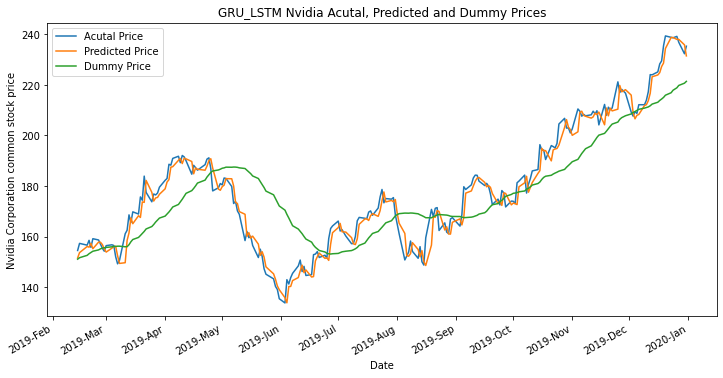

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

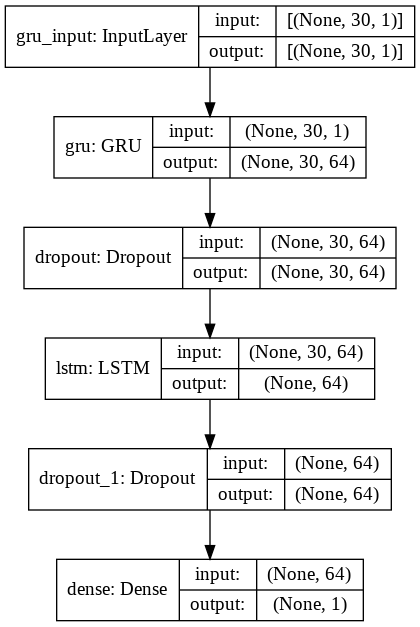

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.001960237133360734
RMSE:  0.04427456530967564
MAE:  0.034556690083441054
Dummy MSE:  0.01623808785220405
Dummy RMSE:  0.12742875598625314
Dummy MAE:  0.10320580289003882


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Nvidia/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Nvidia/assets
